In [1]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.dates as mdates
import torch
import numpy as np 
from typing import Tuple, List
from torch.utils.data import DataLoader, TensorDataset
from torch import nn as nn 
from torch.optim import Adam
import random
from scipy.signal import savgol_filter
from itertools import product

# Set seeds for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Load and preprocess the dataset

In [2]:
# Reading sales and calendar data
calender_df = pd.read_csv('m5-forecasting-accuracy/calendar.csv')
sales_eval_df = pd.read_csv('m5-forecasting-accuracy/sales_train_evaluation.csv')

# Clean sales data
sales_eval_df['id'] = sales_eval_df['id'].str.replace('_evaluation', '') # Standardize 'id' by removing '_evaluation'
sales_eval_df = sales_eval_df.drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id','state_id']) # Remove non-essential columns
sales_eval_df = sales_eval_df.set_index('id') # Set 'id' names as index
sales_eval_df.index.name = None

# Ensure no duplicate rows
assert sales_eval_df.duplicated().sum() == 0 
assert calender_df.duplicated().sum() == 0

### Feature extraction

In [3]:
item_index= 30073  # Selecting a particular item for analysis
daywise_sale = sales_eval_df.T.reset_index().rename(columns={'index': 'd'})  # Reshape sales data to daywise
calender_df_2 = calender_df[['date', 'weekday', 'd', 'event_type_1']] # Select relevant calendar features
day_cal_merged = calender_df_2.merge(daywise_sale, on='d') # Merge sales data with calendar data based on 'd' column
day_cal_merged.head(2)

# Add lag features, rolling window mean and std features
for i in [7,14,30,180,365]:
    day_cal_merged['lag_'+str(i)] = day_cal_merged.iloc[:, item_index].transform(lambda x: x.shift(i).bfill())
    day_cal_merged['window_mean_'+str(i)] = day_cal_merged.iloc[:, item_index].transform(lambda x: x.shift(1).rolling(i).mean().bfill())
    day_cal_merged['window_std_'+str(i)] = day_cal_merged.iloc[:, item_index].transform(lambda x: x.shift(1).rolling(i).std().bfill())

# Create final dataframe with only features and target item sale columns
dates_cols = day_cal_merged.columns[0:4].tolist()   # 'date', 'weekday', 'd', 'event_type_1'
lag_window_cols =day_cal_merged.columns[30494:].tolist() # All lags and rolling window features
target_col = day_cal_merged.iloc[:, item_index].name  # Name of target column
df_mv = day_cal_merged.reindex(columns=dates_cols+lag_window_cols+[target_col]) # Make new dataframe with necessary columns only
df_mv = df_mv.set_index('date') # Set 'date' as index


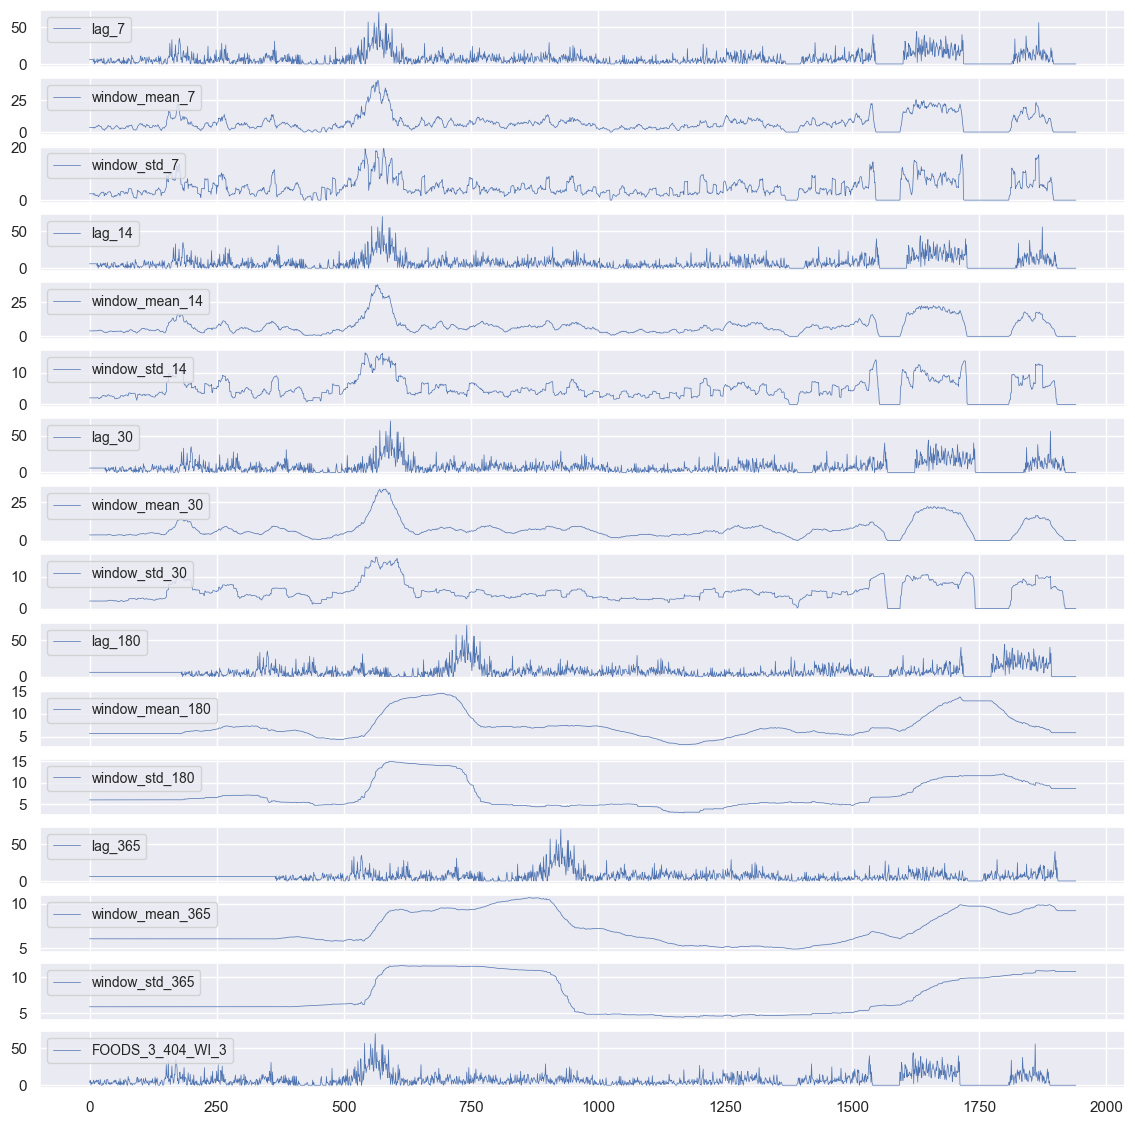

In [4]:
# Create subplots (16 rows, 1 column)
fig, axs = plt.subplots(nrows=16, ncols=1, figsize=(14,14))
# Loop through selected columns and plot them in separate subplots
for idx, i in enumerate(range(3, len(df_mv.columns))):
    axs[idx].plot(df_mv.iloc[:, i].tolist(), lw=0.5, label=df_mv.columns[i])
    axs[idx].legend(fontsize='small', loc='upper left')
plt.show() # Display plots
    

### Feature engineering

In [5]:
# Make a weekend a feature
df_mv.rename(columns={'weekday':'weekend'}, inplace=True) # Rename column 'weekday' to 'weekend' 
df_mv['weekend']= df_mv['weekend'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0, ) # Map weekend to 1 and weekday to 0
# df_mv = df_mv.drop(columns='d') # Drop unnecessary columns
df_mv['weekend'].value_counts()

# Numerical mapping of event categories
df_mv['event_type_1'] = df_mv['event_type_1'].fillna('No event') # Fill nan event type with 'No Event'
df_mv['event_type_1'] = df_mv['event_type_1'].astype('category').cat.codes # Map event categories to numerical values
df_mv.drop(columns=['d'], inplace=True)

# Preserve dates
df_mv_dates = df_mv.index


### Normalization

We will look at the distribution of our sales data first and decide which scaler to use.

In [6]:
print(df_mv.iloc[:,-1].value_counts().to_dict())

{0: 391, 3: 144, 4: 142, 2: 131, 5: 131, 6: 113, 7: 112, 1: 111, 8: 74, 9: 73, 10: 70, 11: 60, 12: 50, 14: 46, 13: 33, 15: 25, 17: 24, 18: 21, 16: 20, 19: 19, 22: 13, 28: 13, 23: 13, 20: 12, 24: 11, 26: 9, 25: 9, 21: 9, 29: 8, 33: 7, 31: 7, 32: 5, 36: 5, 27: 4, 34: 4, 40: 3, 55: 2, 35: 2, 38: 2, 56: 2, 51: 1, 70: 1, 45: 1, 50: 1, 30: 1, 41: 1, 48: 1, 57: 1, 44: 1, 39: 1, 37: 1}


Sales frequency shows **a high frequency of small values (0–10)** with occasional larger values, creating a **right-skewed distribution**. Given this pattern, **MinMax scaling (-1,1) is beneficial** because:  

- **Handles low but non-zero sales effectively:**  
  If zeros were extremely dominant, MinMax might struggle. However, since small values (1–10) occur frequently, MinMax ensures that **0 is mapped to -1** and small sales values are **not overly compressed**.  

- **Why not MinMax (0,1)?**  
  LSTMs often use **tanh activation**, which performs better when inputs are scaled between **(-1,1)** rather than (0,1).  

- **Why not log transformation?**  
  Log scaling would **overcompress larger values**, which is unnecessary in this case since large sales numbers are rare.  

- **Why not StandardScaler?**  
  Standardization (**mean=0, std=1**) assumes a **normal distribution**, which this data does not follow.  

- **Prevents rare high sales from dominating:**  
  Since values like **57, 44, etc., appear infrequently**, MinMax ensures they **don’t overshadow** the training process.  

In [7]:
# Initialize MinMaxScaler to scale data between -1 and 1
scaler_mv = MinMaxScaler((-1,1))  
df_mv_normalized = pd.DataFrame(scaler_mv.fit_transform(df_mv)) # Fit scaler on data

# Create dataframe of normalized datapoints
df_mv_normalized.columns = df_mv.columns # Restore column names from unscaled dataframe
df_mv_normalized['date'] = df_mv_dates.values # Restore 'dates' column from unscaled dataset
df_mv_normalized.set_index('date', inplace=True) # Set 'dates' as index again to maintain timeseries structure

df_mv_normalized.describe() # Summary statistics of normalized data

,weekend,event_type_1,lag_7,window_mean_7,window_std_7,lag_14,window_mean_14,window_std_14,lag_30,window_mean_30,window_std_30,lag_180,window_mean_180,window_std_180,lag_365,window_mean_365,window_std_365,FOODS_3_404_WI_3
count,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,-0.427099,-0.010046,-0.793612,-0.647147,-0.536090,-0.792993,-0.621543,-0.406524,-0.791580,-0.566740,-0.353173,-0.793788,-0.276587,-0.315175,-0.811364,-0.211796,-0.206370,-0.794230
std,0.904438,0.201865,0.235578,0.312796,0.351338,0.235260,0.319641,0.393331,0.234526,0.342386,0.372913,0.223512,0.483778,0.519101,0.192756,0.607654,0.719823,0.235894
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,0.000000,-0.971429,-0.839161,-0.755398,-0.971429,-0.816479,-0.651061,-0.942857,-0.772228,-0.593837,-0.942857,-0.559055,-0.673079,-0.914286,-0.618913,-0.857525,-0.971429
50%,-1.000000,0.000000,-0.857143,-0.720280,-0.605463,-0.857143,-0.689139,-0.492452,-0.857143,-0.630370,-0.413305,-0.828571,-0.405512,-0.496523,-0.828571,-0.541371,-0.598100,-0.857143
75%,1.000000,0.000000,-0.714286,-0.545455,-0.385393,-0.714286,-0.531835,-0.207591,-0.714286,-0.484515,-0.218552,-0.742857,-0.264764,-0.053662,-0.771429,0.480851,0.611565,-0.714286
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- All datapoints in normalized dataframe lies between -1 to 1.

In [8]:
# Generate input-output sequences for time series forecasting
def create_seq(data: pd.DataFrame, seq_len: int) -> Tuple [np.ndarray, np.ndarray]:
    """
    Generate input output sequences for time series forecasting. 
    Uses the last column as the target. 
    Generates (len(data) - seq_len) samples.
    """
    X_seq=[] # To store input sequences
    y_seq=[] # To store corresposnding target values
    for i in range((data.__len__())-seq_len):  # Loop through dataset 
        X_seq.append(np.array(data.iloc[i:i+seq_len, :-1]).tolist()) # Extract features and add to input sequence list
        y_seq.append(np.array(data.iloc[i+seq_len, -1]).tolist())  # Extract target values and add to target list
    return np.array(X_seq), np.array(y_seq).reshape(-1,1)  # Convert to NumPy arrays

seq_len=28
X_seq, y_seq = create_seq(df_mv_normalized, seq_len)
print(f"{X_seq.shape=}, {y_seq.shape=}") # Ensure shapes of input and target are correct

X_seq.shape=(1913, 28, 17), y_seq.shape=(1913, 1)


In [9]:
# Split dataset into training, validation, and test sets

total_len: int = X_seq.shape[0]

# Define training set indices as 80% of data
train_index: int = int(total_len*0.8)
X_mv_train, y_mv_train = X_seq[:train_index], y_seq[:train_index]

# Define validation set indices (next 10% of data)
val_index: int = train_index+int(0.1*total_len)
X_mv_val, y_mv_val = X_seq[train_index:val_index], y_seq[train_index:val_index]

# Assign remaining 10% of data to the test set
X_mv_test, y_mv_test = X_seq[val_index:], y_seq[val_index:]

print(f"{X_mv_train.shape=}, {y_mv_train.shape=}\n{X_mv_val.shape=}, {y_mv_val.shape=}\n{X_mv_test.shape=}, {y_mv_test.shape=}")

X_mv_train.shape=(1530, 28, 17), y_mv_train.shape=(1530, 1)
X_mv_val.shape=(191, 28, 17), y_mv_val.shape=(191, 1)
X_mv_test.shape=(192, 28, 17), y_mv_test.shape=(192, 1)


### Create tensor -> dataset -> dataloader

In [10]:
# Create numpy arrays to pytorch tensors
def create_tensor(data: np.ndarray, dtype: torch.dtype)-> torch.Tensor:
    """ 
    Converts a numpy array to a Tensor.
    """
    return torch.tensor(data,dtype=dtype)

# Wrap input and target tensors into TensorDataset objects
def create_dataset(input_tensor: torch.Tensor, target_tensor: torch.Tensor)-> TensorDataset:
    """ 
    Wraps input output tensors into LSTM compatible Datasets.
    """
    return TensorDataset(input_tensor, target_tensor)

# Initialize DataLoader for batch processing in DL
def get_dataloader(data: TensorDataset, batch_size: int) -> DataLoader:
    """ 
    Creates dataloader batches for processing in a Deep Learning NN.
    """
    return DataLoader(dataset=data, batch_size=batch_size)

# Create train, validation, and test tensors from splitted sequences
dtype= torch.float32
X_mv_tensor, y_mv_tensor = create_tensor(X_seq, dtype=dtype), create_tensor(y_seq, dtype=dtype)

X_mv_train_tensor = create_tensor(X_mv_train, dtype=dtype)
y_mv_train_tensor = create_tensor(y_mv_train, dtype=dtype)

X_mv_val_tensor = create_tensor(X_mv_val, dtype=dtype)
y_mv_val_tensor = create_tensor(y_mv_val, dtype=dtype)

X_mv_test_tensor = create_tensor(X_mv_test, dtype=dtype)
y_mv_test_tensor = create_tensor(y_mv_test, dtype=dtype)

print(f"{X_mv_tensor.shape=}, {y_mv_tensor.shape=}\n{X_mv_train_tensor.shape=}, {y_mv_train_tensor.shape=}\n{X_mv_val_tensor.shape=}, {y_mv_val_tensor.shape=}\n{X_mv_test_tensor.shape=}, {y_mv_test_tensor.shape=}")

X_mv_tensor.shape=torch.Size([1913, 28, 17]), y_mv_tensor.shape=torch.Size([1913, 1])
X_mv_train_tensor.shape=torch.Size([1530, 28, 17]), y_mv_train_tensor.shape=torch.Size([1530, 1])
X_mv_val_tensor.shape=torch.Size([191, 28, 17]), y_mv_val_tensor.shape=torch.Size([191, 1])
X_mv_test_tensor.shape=torch.Size([192, 28, 17]), y_mv_test_tensor.shape=torch.Size([192, 1])


In [11]:
# Wrap train, validation, and test torch tensors in respective torch dataset
full_mv_dataset = create_dataset(X_mv_tensor, y_mv_tensor)
train_mv_dataset = create_dataset(X_mv_train_tensor, y_mv_train_tensor)
val_mv_dataset = create_dataset(X_mv_val_tensor, y_mv_val_tensor)
test_mv_dataset = create_dataset(X_mv_test_tensor, y_mv_test_tensor)

# Divide train, validation, and test datsets into dataloader batches
batch_size_mv= 32 # Define batch size
full_mv_dataloader = get_dataloader(full_mv_dataset, batch_size=batch_size_mv)
train_mv_dataloader = get_dataloader(train_mv_dataset, batch_size=batch_size_mv)
val_mv_dataloader = get_dataloader(val_mv_dataset,batch_size_mv)
test_mv_dataloader = get_dataloader(test_mv_dataset,batch_size_mv)

# Verify shape of input and target tensors in a batch
for input, target in train_mv_dataloader:
    print(f"{input.shape=}") # Expected: (batch_size, seq_len, num_features)
    print(f"{target.shape=}") # Expected: (batch_size, num_class)
    break

input.shape=torch.Size([32, 28, 17])
target.shape=torch.Size([32, 1])


In [12]:
# Define LSTM model for sales prediction
class SalesLSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float=0):
        """
        Initialize the SalesLSTM model.
        Parameters:
        - input_size: Number of input features per time step.
        - hidden_size: Number of units in the hidden layers.
        - num_layers: Number of LSTM layers.
        - output_size: Number of outputs from final layer.
        - dropout: Dropout rate to prevent overfitting.
        """
        super(SalesLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.dropouts = nn.Dropout(p=dropout)
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_layers=num_layers,
                            batch_first=True, 
                            dropout=dropout)  # Define LSTM layer
        self.fc = nn.Linear(hidden_size,1) # Fully connected layer to generate final output
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass of the model.
        Parameters:
        - x: Input tensor of shape (batch_size, sequence_length, input_size).
        Returns:
        - Predicted sales values.
        """
        all_hs_out, (h_n, c_n) = self.lstm(x)  # LSTM forward pass
                                               # all_hs_out shape (batch_size, seq_len, hidden_size)
        final_hidden_state = self.fc(h_n[-1])  # Select last time step output of hidden layer --shape (batch_size, hidden_size)
        # output = self.sigmoid(final_hidden_state)
        return final_hidden_state

### **Hyperparameter Tuning**

#### **Understanding the input shapes of our model**

| **Tensor** | **Shape** | **Description** |
|------------|-----------|----------------|
| **X_mv_tensor** | (1913, 28, 17) | 1913 samples, 28 time steps, 17 features per time step (e.g., sales data, promotions, holidays, etc.) |
| **y_mv_tensor** | (1913, 1) | Predicting a single value (next day’s sales) |
| **Training Set** | (1530, 28, 17) | Used for model learning |
| **Validation Set** | (191, 28, 17) | Used for tuning hyperparameters |
| **Test Set** | (192, 28, 17) | Used for final model evaluation |

Since our dataset has **1530 training samples**, we need to **balance learning capacity and prevent overfitting** while tuning hyperparameters.


#### **Choosing suitable hyperparameters for our model**

| **Hyperparameter** | **Purpose** | **Considerations** | **Chosen Values** |
|--------------------|------------|--------------------|-------------------|
| **Hidden Size (`hidden_size_mv`)** | Defines the number of neurons in each LSTM layer. | - Should be at least comparable to the **17 input features per time step**.<br>- **Too small (<8):** Won’t capture complex patterns.<br>- **Too large (>64):** Risk of overfitting due to limited data. | `[8, 16, 32, 64]` <br>- **8** → Minimal capacity, suitable for simple patterns.<br>- **16-32** → Balanced choice, captures important temporal dependencies.<br>- **64** → More capacity but may lead to overfitting. |
| **Dropout (`dropout`)** | Prevents overfitting by randomly deactivating neurons during training. | - **Too high (>0.3):** Could hurt learning due to small training set (1530 samples).<br>- **Too low (<0.1):** Won’t prevent overfitting. | `[0.1, 0.2]` <br>- **0.1** → Keeps most neurons active, allowing more learning.<br>- **0.2** → Adds stronger regularization to prevent overfitting. |
| **Number of Layers (`num_layers_mv`)** | Defines the depth of the LSTM network. | - More layers capture deeper patterns but also increase complexity.<br>- **Dataset size is relatively small (1530 samples), so >2 layers may overfit.** | `[1, 2]` <br>- **1 layer** → Good for capturing short-term dependencies.<br>- **2 layers** → Adds some depth to learn more complex patterns.<br>- **>2 layers** is unnecessary for this dataset. |
| **Number of Epochs (`num_epochs_mv`)** | Controls how many times the model sees the entire dataset during training. | - **Too few (<50):** Model might underfit and not learn patterns well.<br>- **Too many (>100):** Model might memorize training data, leading to overfitting.<br>- **Early stopping can help prevent overfitting.** | `[50, 100]` <br>- **50 epochs** → Good baseline for learning key patterns.<br>- **100 epochs** → Allows more learning but needs monitoring for overfitting. |


In [13]:
# Hyperparameter grid
param_grid = {
    "hidden_size_mv": [8, 16, 32, 64],
    "dropout": [0.1, 0.2],
    "num_layers": [1, 2],
    "num_epochs_mv": [50, 100]
}

# All possible hyperparameter combinations
param_combinations = list(product(
    param_grid["hidden_size_mv"], 
    param_grid["dropout"], 
    param_grid["num_layers"], 
    param_grid["num_epochs_mv"]
))

best_val_loss = float('inf')
best_params = None
input_size_mv = X_mv_tensor.shape[2] 

for hidden_size_mv, dropout, num_layers_mv, num_epochs_mv in param_combinations:
    print(f"\nTesting: hidden_size={hidden_size_mv}, dropout={dropout}, num_layers={num_layers_mv}, epochs={num_epochs_mv}")
    
    # Initialize model with current hyperparameters
    model_mv = SalesLSTM(input_size_mv, hidden_size_mv, num_layers_mv, dropout=dropout)  
    criterion = nn.MSELoss()
    optimizer = Adam(model_mv.parameters(), lr=0.0001)

    # Training loop
    for epoch in range(num_epochs_mv):
        model_mv.train()
        total_loss = 0

        for input, target in train_mv_dataloader:
            optimizer.zero_grad()
            output = model_mv(input)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_mv_dataloader)

        # Validation
        model_mv.eval()
        total_val_loss = 0
        with torch.no_grad():
            for input, target in val_mv_dataloader:
                output = model_mv(input)
                val_loss = criterion(output, target)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_mv_dataloader)

        # Store best parameters
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_params = {
                "hidden_size_mv": hidden_size_mv,
                "dropout": dropout,
                "num_layers": num_layers_mv,
                "num_epochs_mv": num_epochs_mv
            }
    
    print(f"Validation Loss: {avg_val_loss:.4f}")

print("\nBest Hyperparameters:", best_params)
print("Best Validation Loss:", best_val_loss)



Testing: hidden_size=8, dropout=0.1, num_layers=1, epochs=50


/opt/anaconda3/envs/libraries/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Validation Loss: 0.0769

Testing: hidden_size=8, dropout=0.1, num_layers=1, epochs=100


/opt/anaconda3/envs/libraries/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Validation Loss: 0.0964

Testing: hidden_size=8, dropout=0.1, num_layers=2, epochs=50
Validation Loss: 0.0863

Testing: hidden_size=8, dropout=0.1, num_layers=2, epochs=100
Validation Loss: 0.0689

Testing: hidden_size=8, dropout=0.2, num_layers=1, epochs=50


/opt/anaconda3/envs/libraries/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Validation Loss: 0.0662

Testing: hidden_size=8, dropout=0.2, num_layers=1, epochs=100
Validation Loss: 0.0682

Testing: hidden_size=8, dropout=0.2, num_layers=2, epochs=50
Validation Loss: 0.0777

Testing: hidden_size=8, dropout=0.2, num_layers=2, epochs=100
Validation Loss: 0.0699

Testing: hidden_size=16, dropout=0.1, num_layers=1, epochs=50
Validation Loss: 0.0626

Testing: hidden_size=16, dropout=0.1, num_layers=1, epochs=100
Validation Loss: 0.0632

Testing: hidden_size=16, dropout=0.1, num_layers=2, epochs=50
Validation Loss: 0.0738

Testing: hidden_size=16, dropout=0.1, num_layers=2, epochs=100
Validation Loss: 0.0836

Testing: hidden_size=16, dropout=0.2, num_layers=1, epochs=50
Validation Loss: 0.0640

Testing: hidden_size=16, dropout=0.2, num_layers=1, epochs=100
Validation Loss: 0.0624

Testing: hidden_size=16, dropout=0.2, num_layers=2, epochs=50
Validation Loss: 0.0680

Testing: hidden_size=16, dropout=0.2, num_layers=2, epochs=100
Validation Loss: 0.0835

Testing: hidden

In [14]:
# Hyperparameters
input_size_mv = X_mv_tensor.shape[2] 
hidden_size_mv = 32 # Number of LSTM units
num_layers_mv = 1 # Number of LSTM layers


# Create model instance
model_mv= SalesLSTM(input_size_mv, hidden_size_mv, num_layers_mv, dropout=0.1) 
print(f"{model_mv=}")

# Define loss and optimization functions
criterion = nn.MSELoss()  # Mean Squared Error for regression problems
lr_mv = 0.0001 # Define learning rate
optimizer = Adam(model_mv.parameters(), lr=lr_mv)  # Adam optimizer for adaptive learning
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training model
num_epochs_mv = 100
avg_loss_list =[]
avg_val_loss_list= []
for epoch in range(num_epochs_mv):
    model_mv.train()  # Set model to training mode
    total_loss = 0

    # Iterate over training data batches
    for input, target in train_mv_dataloader:
        optimizer.zero_grad()  # Clean previous gradients
        # print(input.shape)
        output = model_mv(input)  # Forward pass
        loss = criterion(output, target) # Compute loss
        loss.backward()  # Find gradients by backpropagation
        optimizer.step() # Update model weights 
        total_loss+=loss.item() # Collect total loss for a batch
    avg_loss = total_loss/len(train_mv_dataloader) # Avg training loss per batch
    avg_loss_list.append(avg_loss)
    if epoch%20==0:
        print(f"Epoch: {epoch}/{num_epochs_mv}, Avg Loss: {avg_loss:.4f}")
        # scheduler.step(avg_loss)

    # Evaluate model on valiation data
    model_mv.eval()  # Set model to evaluation mode to drop dropout
    total_val_loss = 0
    with torch.no_grad():  # Ensure no gradient updates 
        for input, target in val_mv_dataloader:  
            output = model_mv(input) # Forward pass
            val_loss = criterion(output, target) # Find valiadtion loss
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss/len(val_mv_dataloader)
    avg_val_loss_list.append(avg_val_loss)
    if epoch%20==0:
        print(f"\t     Avg val loss: {avg_val_loss:.4f}")

model_mv=SalesLSTM(
  (lstm): LSTM(17, 32, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0/100, Avg Loss: 0.7625
	     Avg val loss: 0.5339
Epoch: 20/100, Avg Loss: 0.0326
	     Avg val loss: 0.0678
Epoch: 40/100, Avg Loss: 0.0307
	     Avg val loss: 0.0679
Epoch: 60/100, Avg Loss: 0.0294
	     Avg val loss: 0.0657
Epoch: 80/100, Avg Loss: 0.0284
	     Avg val loss: 0.0647


<Axes: title={'center': 'Average training and validation loss'}, xlabel='epoch', ylabel='loss'>

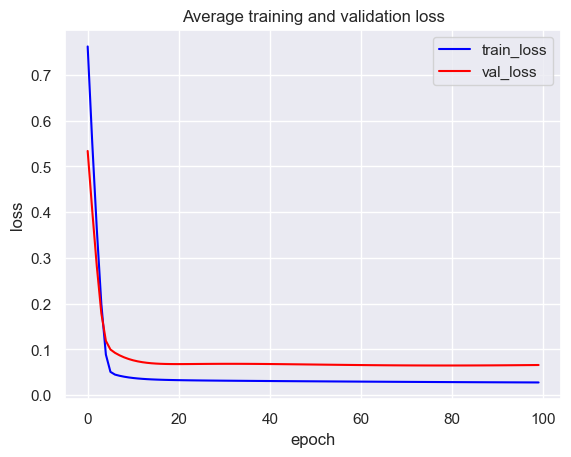

In [15]:
loss_df = pd.DataFrame({'epoch': [i for i in range(num_epochs_mv)], 'train_loss': avg_loss_list, 'val_loss': avg_val_loss_list})
loss_df.set_index('epoch', inplace=True)
loss_df.plot(kind='line', ylabel='loss', title= 'Average training and validation loss', colormap='bwr')

- The loss graph shows a well-trained model with both training loss decreasing from 0.8 to 0.03 and validation loss reducing from 0.6 to 0.05, indicating effective learning and good generalization. 
- Initially, high loss values suggest the model was untrained, but as training progresses, the steady decline in both losses demonstrates that the model is capturing meaningful patterns. 
- The final small gap between training and validation loss suggests no significant overfitting, meaning the model performs well on unseen data. This indicates that the chosen architecture and hyperparameters are well-suited for the task.

In [16]:
# Evaluate model performance on the full dataset
model_mv.eval()  # Set model to evaluation mode
full_loss = 0
actual_output_full_mv = []
predicted_output_full_mv = []
with torch.no_grad():  # Disable gradient calculation
    for input, target in full_mv_dataloader:
        output = model_mv(input)  # Forward pass
        predicted_output_full_mv.extend(output.numpy().flatten().tolist()) # Store predicted values
        actual_output_full_mv.extend(target.detach().numpy().reshape(-1).tolist()) # Store actual values
        loss = criterion(output, target) # Compute test loss
        full_loss += loss.item()
avg_test_loss = full_loss / len(full_mv_dataloader)
print(f"full dataset Loss: {avg_test_loss:.4f}")

full dataset Loss: 0.0319


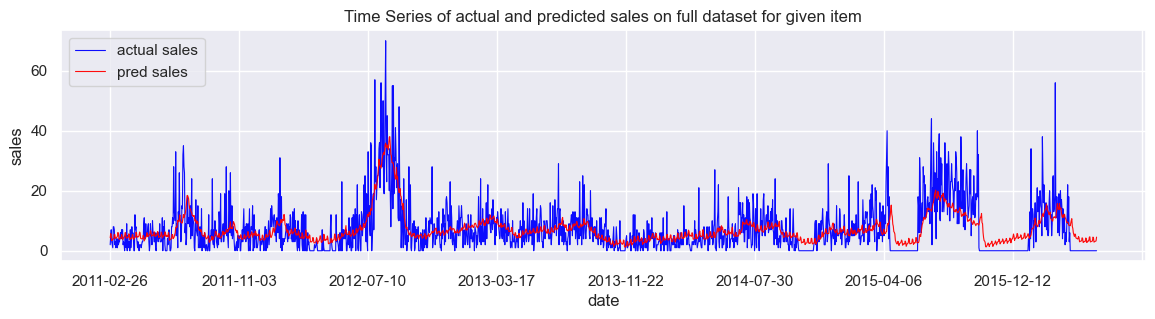

In [17]:
# Reverse normalization to obtain actual scale values
target_scaler = MinMaxScaler((-1,1))
target = df_mv.iloc[:, -1].values.reshape(-1,1)
target_scaler.fit_transform(target)

predicted_unscaled_mv = target_scaler.inverse_transform(np.array(predicted_output_full_mv).reshape(-1,1))
actual_unscaled_mv = target_scaler.inverse_transform(np.array(actual_output_full_mv).reshape(-1,1))
# Create a DataFrame for actual vs. predicted sales
full_df_mv= pd.DataFrame({'actual sales': actual_unscaled_mv.reshape(-1).tolist(), 'pred sales':predicted_unscaled_mv.reshape(-1).tolist(), 'date':df_mv[seq_len:].index})
full_df_mv.set_index('date', inplace=True)
full_df_mv.plot(kind='line', figsize=(14,3), alpha=0.95, colormap='bwr',lw=0.8, ylabel='sales', title='Time Series of actual and predicted sales on full dataset for given item')
plt.show()

- The initial grid up to nearly **2015-04-06** is our **training data**. Following that is the **validation and test data**.  
- Across all the time duration (**train, val, test**), the **predicted values move up and down in sync with the overall trend**, which means that the model understands the **broader sales pattern**.  
- However, it **does not fully capture the extreme highs and lows**, which could indicate some **smoothing effect** in the predictions.  
  This could be due to the model **prioritizing overall trend learning over short-term noise** or being slightly **under-responsive to sudden spikes and drops**.  
- Despite this, the model **looks valuable for forecasting**, as it provides a **good general direction of future values**, even if it doesn’t predict every peak and dip perfectly.  


test dataset Loss: 0.0368


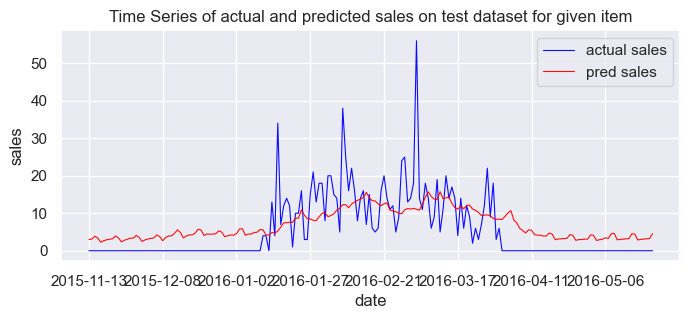

In [18]:
# Evaluate model performance on the test dataset
model_mv.eval()  # Set model to evaluation mode
test_loss = 0
actual_output_test_mv = []
predicted_output_test_mv = []
with torch.no_grad():  # Disable gradient calculation
    for input, target in test_mv_dataloader:
        output = model_mv(input)  # Forward pass
        predicted_output_test_mv.extend(output.numpy().flatten().tolist()) # Store predicted values
        actual_output_test_mv.extend(target.detach().numpy().reshape(-1).tolist()) # Store actual values
        loss = criterion(output, target) # Compute test loss
        test_loss += loss.item()
avg_test_loss = test_loss / len(test_mv_dataloader)
print(f"test dataset Loss: {avg_test_loss:.4f}")

predicted_test_unscaled_mv = target_scaler.inverse_transform(np.array(predicted_output_test_mv).reshape(-1,1))
actual_test_unscaled_mv = target_scaler.inverse_transform(np.array(actual_output_test_mv).reshape(-1,1))
# Create a DataFrame for actual vs. predicted sales
test_df_mv= pd.DataFrame({'actual sales': actual_test_unscaled_mv.reshape(-1).tolist(), 'pred sales':predicted_test_unscaled_mv.reshape(-1).tolist(), 'date':df_mv[val_index+seq_len:].index})
test_df_mv.set_index('date', inplace=True)
test_df_mv.plot(kind='line', figsize=(8,3), alpha=0.95,colormap='bwr', lw=0.8, ylabel='sales', title= 'Time Series of actual and predicted sales on test dataset for given item' )
plt.show()

- The test data graph also shows that the predicted values follow the overall trend well, maintaining consistency with the observed sales pattern.  


### Directional Accuracy of model

In [19]:
# Correlation between actual and predicted sales in test data
r_value = np.corrcoef(test_df_mv['actual sales'], test_df_mv['pred sales'])[0, 1]
print("Correlation Coefficient (R-value):", r_value)

Correlation Coefficient (R-value): 0.6715405204603795


- Correlation of 0.677 falls in between the moderate to strong range of correlation, which means that **our model follows the actual sales trend fairly well but not perfectly**.
- Let's smoothen the actual data to show our predictions follow a long-term pattern. We can also find out the duration which our model is capable of capturing.
- We will use Savitzky-Golay smoothening.

Model's accuracy for capturing 14 day's trend is 45.87%
Model's accuracy for capturing 30 day's trend is 52.25%
Model's accuracy for capturing 90 day's trend is 61.19%
Model's accuracy for capturing 120 day's trend is 63.44%
Model's accuracy for capturing 150 day's trend is 62.03%
Model's accuracy for capturing 180 day's trend is 62.71%
Model's accuracy for capturing 305 day's trend is 59.1%


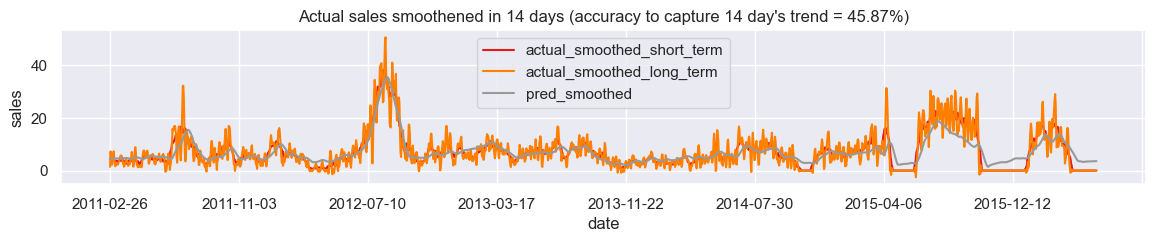

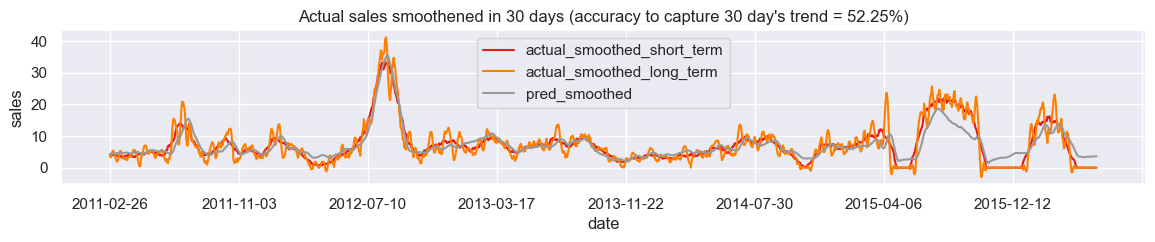

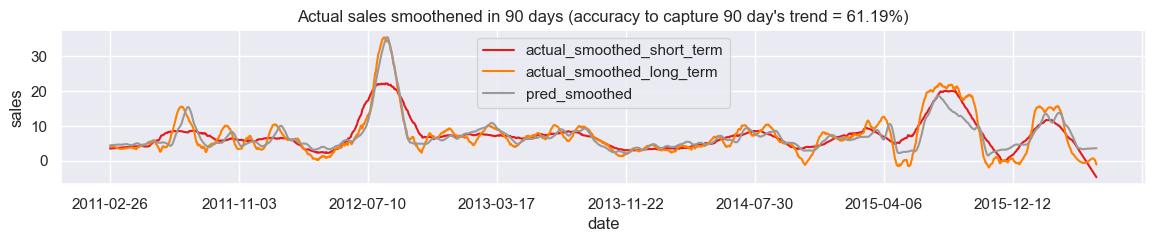

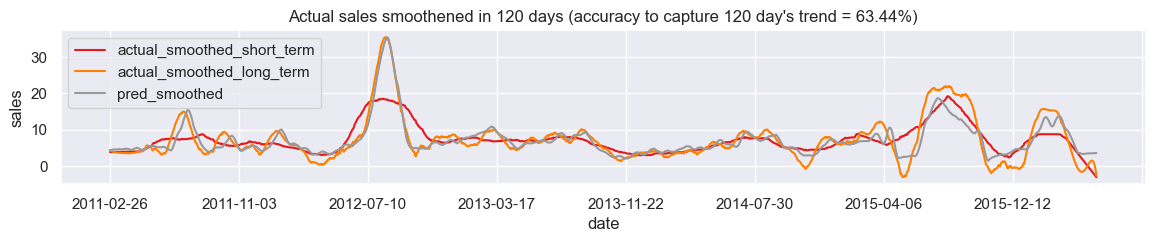

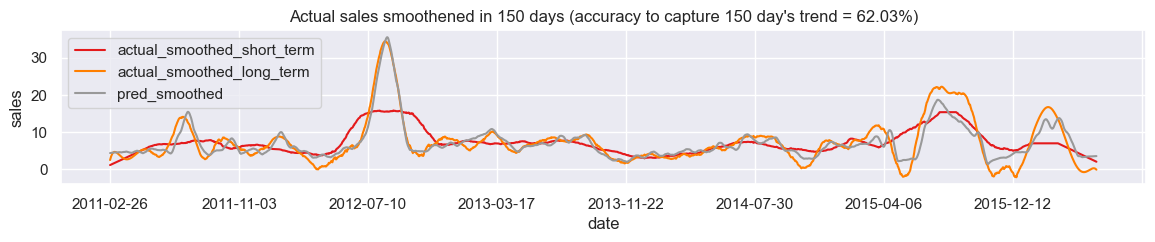

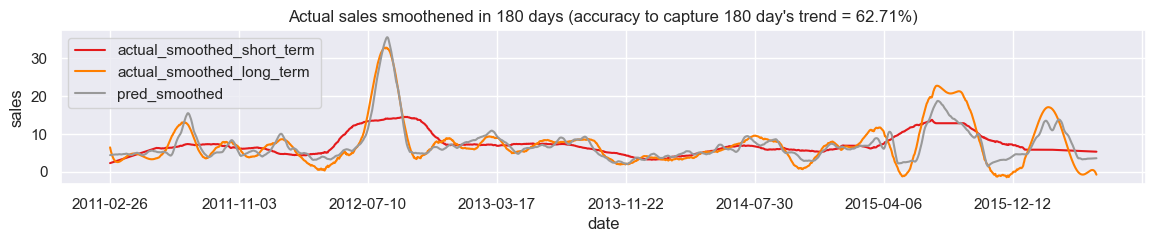

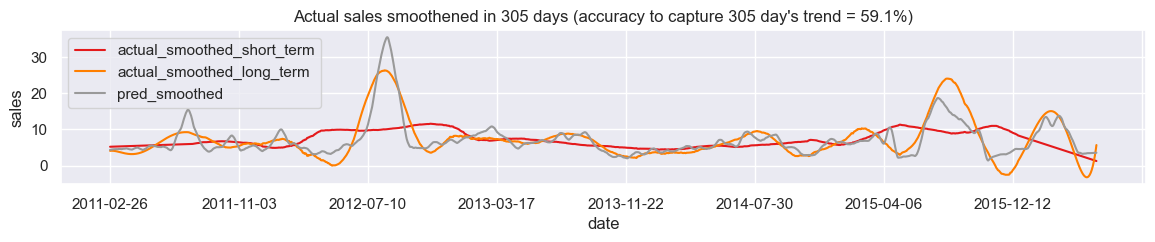

In [22]:
window_size= [14,30,90,120,150,180,305]
# Slightly smoothen the predicted values
full_df_mv['pred_smoothed'] = savgol_filter(full_df_mv['pred sales'], window_length=28, polyorder=2)
                     
for window in window_size:
    full_df_mv['actual_smoothed_short_term'] = savgol_filter(full_df_mv['actual sales'], window_length=window, polyorder=1)
    full_df_mv['actual_smoothed_long_term'] = savgol_filter(full_df_mv['actual sales'], window_length=window, polyorder=6)
    full_df_mv['actual_trend_short_term'] = np.sign(full_df_mv['actual_smoothed_short_term'].diff())  # +1 for up, -1 for down
    full_df_mv['actual_trend_long_term'] = np.sign(full_df_mv['actual_smoothed_long_term'].diff())  # +1 for up, -1 for down
    full_df_mv['pred_trend'] = np.sign(full_df_mv['pred_smoothed'].diff())  # +1 for up, -1 for down
    correct_directions_short_term = (full_df_mv['actual_trend_short_term'] == full_df_mv['pred_trend']).sum()
    correct_directions_long_term = (full_df_mv['actual_trend_long_term'] == full_df_mv['pred_trend']).sum()
    total_points = len(full_df_mv) - 1  # Excluding first row as diff() results in NaN
    short_term_accuracy = (correct_directions_short_term / total_points) * 100
    long_term_accuracy = (correct_directions_long_term / total_points) * 100
    best = max(short_term_accuracy.round(2), long_term_accuracy.round(2))
    print(f"Model's accuracy for capturing {window} day's trend is {best}%")
    plot_df = full_df_mv[['actual_smoothed_short_term','actual_smoothed_long_term','pred_smoothed']]
    plot_df.plot(kind='line', figsize=(14,2), ylabel= 'sales', title = f"Actual sales smoothened in {window} days (accuracy to capture {window} day's trend = {best}%)", colormap='Set1')

- The model's accuracy in capturing trends varies across different time windows, showing a gradual improvement for mid-range windows (90-180 days) but a decline for very short (14-30 days) and very long (300-365 days) trends. 

- Short-term trend accuracy (14-30 days) remains below 53%, indicating that the model struggles to align with daily or weekly fluctuations, likely due to noise in the data. 
  
- The accuracy improves significantly in the 90-180 day range, peaking at 64.91% for 120 days, suggesting that the model captures medium-term patterns more effectively. However, for longer windows (300-365 days), the accuracy drops to around 60%, which may indicate over-smoothing or changing long-term trends. 
  
- Overall, the model performs best in the mid-term range, while adjustments in smoothing parameters could enhance short-term and long-term trend predictions.